# Plotting CO Ice for the Filament

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.table import Table

from spectral_cube import SpectralCube
import importlib as imp
from icemodels.core import composition_to_molweight
from brick2221.analysis.make_icecolumn_fig9 import dmag_tbl # 

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

In [64]:
from brick2221.analysis.make_icecolumn_fig9 import molscomps, compute_molecular_column
from brick2221.analysis.analysis_setup import basepath
dmag_tbl = Table.read(f'{basepath}/tables/combined_ice_absorption_tables.ecsv')
dmag_tbl.add_index('composition')

In [69]:
%cd ..
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(co_map)
import extinction as ex
%cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament
/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [41]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
reg_c1 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc1.region')
reg_c2 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc2.region')
reg_d = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudd.region')

## Catalog

In [23]:
cat_use = make_cat_use()

In [ ]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

cutout_filament = cm.Cutout(pos, w, l)
cutout_405 = cutout_filament.get_cutout_405()

In [36]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], cutout_405.wcs))
#mask_red = (cat_filament.color('f182m', 'f410m') > 2) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = (cat_filament.color('f182m', 'f212n') > 0.55) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = mask_red & (cat_filament.color('f410m', 'f466n') < 0)
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

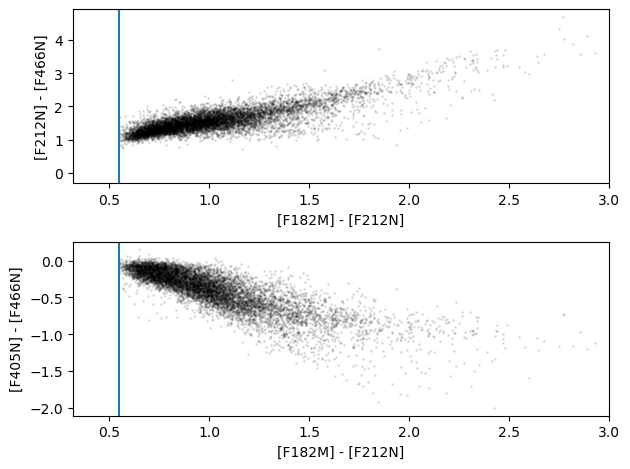

In [ ]:
ax1 = plt.subplot(211)
cat_filament.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', color='k', s=1, ax=ax1, alpha=0.1)
ax1.set_xlim(right=3)

ax2 = plt.subplot(212)
cat_filament.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='k', s=1, ax=ax2, alpha=0.1)
ax2.set_xlim(right=3)

ax1.axvline(0.55)
ax2.axvline(0.55)

plt.tight_layout()

In [42]:
#reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
cat_f = JWSTCatalog(cat_use.table_region_mask(reg_f, cutout_405.wcs))
mask_red = (cat_f.color('f182m', 'f212n') > 0.55) | (np.isnan(np.array(cat_f.band('f182m'))) & np.isnan(np.array(cat_f.band('f187n'))))
mask_red = mask_red & (cat_f.color('f410m', 'f466n') < 0)
cat_f = JWSTCatalog(cat_f.catalog[mask_red])

(0.0, 3.0)

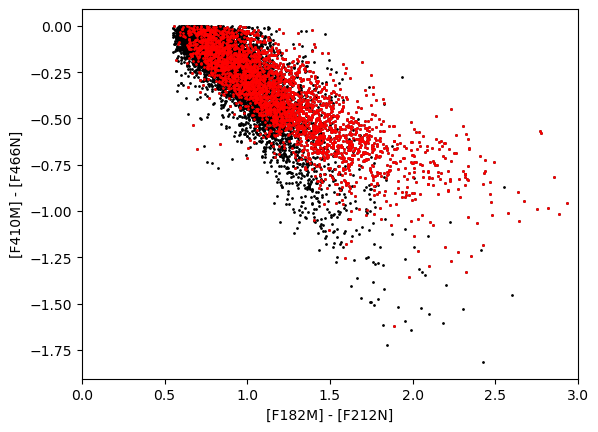

In [43]:
ax = plt.subplot(111)
cat_filament.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='k', s=1)
cat_f.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='r', s=1)
ax.set_xlim(0, 3)

In [51]:
ridge_reg = [reg_d[0], reg_c1[0], reg_c2[0]]
cat_ridge = JWSTCatalog(cat_use.table_region_mask(ridge_reg, cutout_405.wcs))
mask_red = (cat_ridge.color('f182m', 'f212n') > 0.8) | (np.isnan(np.array(cat_ridge.band('f182m'))) & np.isnan(np.array(cat_ridge.band('f187n'))))
mask_red = mask_red & (cat_ridge.color('f410m', 'f466n') < 0)
cat_ridge = JWSTCatalog(cat_ridge.catalog[mask_red])

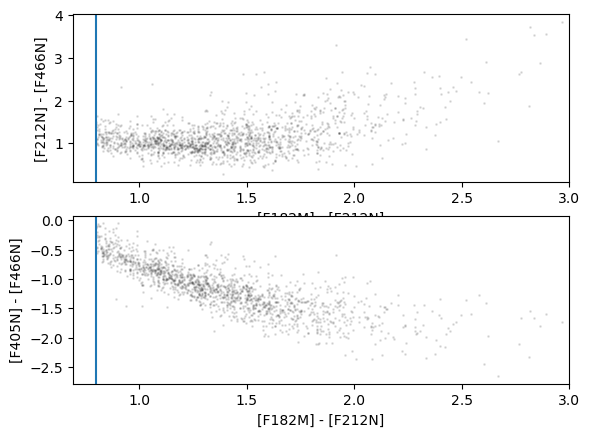

In [52]:
ax1 = plt.subplot(211)
cat_ridge.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', color='k', s=1, ax=ax1, alpha=0.1)
ax1.set_xlim(right=3)

ax2 = plt.subplot(212)
cat_ridge.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='k', s=1, ax=ax2, alpha=0.1)
ax2.set_xlim(right=3)

ax1.axvline(0.8)
ax2.axvline(0.8)

## CO Ice

In [60]:
Av_182212 = cat_filament.get_Av('f182m', 'f212n', ext=CT06_MWLoc())
#cat_filament.catalog['N(CO)'] = co_map.get_co_column(cat_filament, Av_182212, ref_band='f212n', ext=CT06_MWLoc(), consts_file='85_CO_(1)_10K_Hudgins.txt')

In [71]:
dmag_tbl.loc['H2O:CO (10:1)']

molecule,mol_id,molwt,database,author,composition,temperature,density,column,F356W,F410M,F444W,F466N,F405N
,,u,,,,,g / cm3,,,,,,
str37,int64,float64,str5,str34,str66,str5,float64,float64,float64,float64,float64,float64,float64
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,1000000000000000.0,3.183087644131888e-06,8.092935463110962e-06,1.2664519674743246e-05,3.820270411836191e-05,7.4045201081673895e-06
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,1778279410038922.8,5.660411153129985e-06,1.4391494838505992e-05,2.2520952287052864e-05,6.79335655782154e-05,1.3167305576544663e-05
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,3162277660168379.5,1.0065767101608003e-05,2.559208105168409e-05,4.004822230818661e-05,0.00012080006551506983,2.3415148167060806e-05
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,5623413251903491.0,1.7899665726517355e-05,4.5509814190936027e-05,7.121590650349674e-05,0.0002148011070843836,4.1638675158495175e-05
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,1e+16,3.183035195242212e-05,8.0928986532669e-05,0.00012663854728955926,0.00038192845158846467,7.404519644538254e-05
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,1.7782794100389228e+16,5.660245296645883e-05,0.00014391378439526648,0.00022518850305353055,0.0006790239902123574,0.000131673041131819
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,3.162277660168379e+16,0.00010065242637757876,0.00025591712967099056,0.0004004157954540233,0.001207015655989352,0.00023415143539295968
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,5.623413251903491e+16,0.00017898007356187406,0.0004550865021535344,0.0007119492430440744,0.0021448994538069144,0.00041638660520249005


In [ ]:
cat_filament.catalog['N(CO)'] = co_map.get_co_ice_column(cat_filament, Av_182212, ext=CT06_MWLoc(), ref_band='f410m') # H2O:CO_(10:1)

KeyError: 'No matches found for key H2O:CO (10:1)'

In [11]:
co_col_map = co_map.make_co_column_map(cat_filament, cat_filament.catalog['N(CO)'], cutout_405.wcs, cutout_405.shape, fwhm=30, k=5)

Text(0, 0.5, 'N(CO) (cm$^{-2}$)')

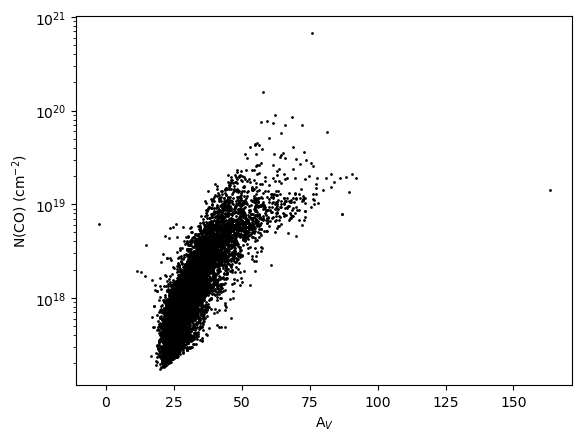

In [18]:
plt.scatter(Av_182212, cat_filament.catalog['N(CO)'], color='k', s=1)
plt.yscale('log')
plt.xlabel('A$_V$')
#plt.ylim(1e19, 1e22)
plt.ylabel('N(CO) (cm$^{-2}$)')

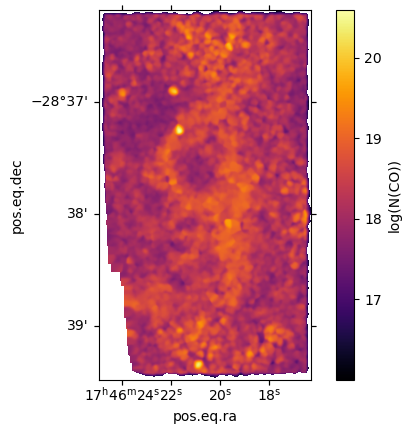

In [16]:
co_col_map[co_col_map < 1e16] = np.nan
ax = plt.subplot(projection=cutout_405.wcs)
im = ax.imshow(np.log10(co_col_map), origin='lower', cmap='inferno')#, vmin=20, vmax=21)
plt.colorbar(im, ax=ax, label='log(N(CO))')

In [14]:
from icemodels.core import composition_to_molweight

In [15]:
composition_to_molweight('CO')

<Quantity 28.010145 u>